In [1]:
from unifloc.pvt.fluid_flow import FluidFlow
from unifloc.equipment.natural_separation import NaturalSeparation
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [2]:
# Инициализация исходных данных класса FluidFlow
q_fluid = 50 / 86400
wct = 0
pvt_model_data = {'black_oil': {'gamma_gas': 0.7, 'gamma_wat': 1, 'gamma_oil': 0.8,
                                'rp': 50,
                                'oil_correlations':
                                 {'pb': 'Standing', 'rs': 'Standing',
                                  'rho': 'Standing','b': 'Standing',
                                  'mu': 'Beggs', 'compr': 'Vasquez'},
                    'gas_correlations': {'ppc': 'Standing', 'tpc': 'Standing',
                                         'z': 'Dranchuk', 'mu': 'Lee'},
                    'water_correlations': {'b': 'McCain', 'compr': 'Kriel',
                                           'rho': 'Standing', 'mu': 'McCain'},
                    'rsb': {'value': 50, 'p': 10000000, 't': 303.15},
                    'muob': {'value': 0.5, 'p': 10000000, 't': 303.15},
                    'bob': {'value': 1.5, 'p': 10000000, 't': 303.15},
                    'table_model_data': None, 'use_table_model': False}}

# Инициализация исходных данных метода расчета pvt-свойств флюидов
p = 4 * (10 ** 6)
t = 350

In [3]:
# Инициализация объекта pvt-модели
fluid_flow = FluidFlow(q_fluid, wct, pvt_model_data)

# Пересчет всех свойств для данного давления и температуры
fluid_flow.calc_flow(p, t)

In [4]:
print(f'dens_l = {fluid_flow.rl: .1f} кг/м3\n'
      f'dens_g = {fluid_flow.rg: .1f} кг/м3\n'
      f'sigma = {fluid_flow.stlg: .3f} Н/м\n'
      f'mu_l = {fluid_flow.mul: .3f} сПз\n'
      f'q_l = {fluid_flow.ql: .5f} м3/с\n'
      f'q_g = {fluid_flow.qg: .5f} м3/с\n'
     )

dens_l =  685.2 кг/м3
dens_g =  29.4 кг/м3
sigma =  0.018 Н/м
mu_l =  0.491 сПз
q_l =  0.00069 м3/с
q_g =  0.00061 м3/с



In [5]:
# Инициализация исходных данных
h_mes_ = 1800
d_tub = 0.063
d_cas = 0.130
q_fluid = fluid_flow.ql
q_gas = fluid_flow.qg
sigma_l = fluid_flow.stlg
rho_liq = fluid_flow.rl
rho_gas = fluid_flow.rg

## General use functions

In [6]:
def v_S(qi: float, r_c: float, r_p: float) -> float:
    return qi / (math.pi * (r_c**2 - r_p**2))

In [7]:
def v_s(dens_l: float, dens_g: float, sigma_l: float, g=9.81) -> float:
    # slip or bubble rise velocity
    return 1.53 * (g * sigma_l * (dens_l - dens_g)/(dens_l**2))**(1/4)

# test
print(f'v_s = {v_s(rho_liq, rho_gas, sigma_l) : .3f} m/s')

v_s =  0.191 m/s


In [8]:
def v_s_inf(dens_l: float, dens_g: float, sigma_l: float, flow_type ='bubble',g=9.81) -> float:
    # slip or bubble rise velocity
    if flow_type == 'bubble':
        return 1.53 * (g * sigma_l * (dens_l - dens_g)/(dens_l**2))**(1/4)
    elif flow_type == 'slug':
        return 2**(1/2) * (g * sigma_l * (dens_l - dens_g)/(dens_l**2))**(1/4)
    else:
        None

# test
print(f'v_s = {v_s(rho_liq, rho_gas, sigma_l) : .3f} m/s')

v_s =  0.191 m/s


In [9]:
def calc_r_d(vi_zsg: float, v_zinf: float, unit='si') -> float or None:
    if unit == 'si':
        return 3 / (71.617 * (1 - math.exp(-2.368 * vi_zsg))) * vi_zsg / (vi_zsg + v_zinf)  # 3.28084
    elif unit == 'field':
        return 3 / (5660.705 * (1 - math.exp(-2.5483248 * vi_zsg))) * vi_zsg / (vi_zsg + v_zinf)  # 3.28084
    else:
        return None

# Check flow type

### See if bubble flow can exist

In [10]:
d_ep = d_cas + d_tub

def check_if_bubble_flow(dens_l, dens_g, sigma_l, d_ep, g=9.81) -> bool:
    return d_ep >= 19.7 * ((dens_l - dens_g) * sigma_l / (g * dens_l**2))**(1/2)

# test
print(f'the bubble flow pattern region in annuli exists : {check_if_bubble_flow(rho_liq, rho_gas, sigma_l, d_ep)}')

the bubble flow pattern region in annuli exists : True


### See if there is transition to slug/churn

In [11]:
def trans_A(v_Sl: float, v_s: float, ann_type='con') -> float:
    # v_Sg = f(v_Sl)
    if ann_type == 'con':
        return v_Sl/4 + 0.20 * v_s
    elif ann_type == 'ecc':
        return v_Sl/5.67 + 0.230 * v_s
    else:
        return None

def check_if_trans_to_slug(v_Sl: float, v_Sg: float, v_s: float) -> bool:
    return v_Sg >= trans_A(v_Sl, v_s, 'con')

# test
v_Sl_test1 = v_S(q_fluid, d_cas/2, d_tub/2)
v_Sg_test1 = v_S(q_gas, d_cas/2, d_tub/2)
v_s_test1 = v_s(rho_liq, rho_gas, sigma_l)

print(f'v_Sl = {v_Sl_test1}')
print(f'v_Sg = {v_Sg_test1}')
print(f'v_s = {v_s_test1}')

print(f'the bubble to slug transition exist : {check_if_trans_to_slug(v_Sl_test1, v_Sg_test1, v_s_test1)}')

v_Sl = 0.06748402644534862
v_Sg = 0.059930202869235755
v_s = 0.19096060125902284
the bubble to slug transition exist : True


# Function to calculate

In [12]:
dens_l = rho_liq
dens_g = rho_gas
mu_l = fluid_flow.mul * 10**(-3)

g = 9.81

r_c = d_cas/2
r_p = d_tub/2
h_p = d_tub + 10*10**(-3)  # м
print(f'r_c = {r_c}')
print(f'r_p = {r_p}')

v_slip = v_s_inf(rho_liq, rho_gas, sigma_l, flow_type='slug')

vi_zl = v_S(q_fluid, d_cas/2, d_tub/2)
vi_zg = v_S(q_gas, d_cas/2, d_tub/2)
tan_beta = (r_c - r_p)/h_p

r_d = calc_r_d(vi_zg, v_slip)
print(f'r_d = {r_d}')

drdz = lambda h, r: 54*mu_l/r_d**2 * 1/((dens_l - dens_g) * g) * (r_p + h/h_p * (r_c - r_p)) * vi_zl * tan_beta * (2/9 * (r_d**2 * dens_l)/mu_l * 1/r**3 * (r_p + h/h_p * (r_c - r_p)) * vi_zl * tan_beta + 1/r)

r_c = 0.065
r_p = 0.0315
r_d = 0.08025194969140448


#### 'RUS' method

In [13]:
step_size = 2000000

dh = h_p/step_size

h_i = h_p
r_i = r_p

for i in tqdm(range(step_size)):
    r_ii = r_c - h_p/h_i * tan_beta
#     print(r_ii)
    varience = r_i - r_ii
#     print(varience)
    
    if abs(varience) <= 10**(-2):
        print(i)
        break
    
    drdz_i = drdz(h_i, r_i)
    
    h_i = h_i + dh
    r_i = r_i + drdz_i * dh
    
print(f'r_i = {r_i}')

100%|████████████████████████████████████████████████████████████████████| 2000000/2000000 [00:07<00:00, 264409.30it/s]

r_i = 0.04297403074212044


#### scipy.integrate

In [14]:
r = tuple(np.linspace(r_c, r_p, num=1000, endpoint=True))
sol_list = []
slo_list_to_plot = []
for i in tqdm(r): 
    sol1 = solve_ivp(drdz, [h_p, 0], [i])
    # sol1
    
    sol_list.append(sol1.y[0][-1])
    slo_list_to_plot.append(sol1)
    
sol1

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2610.75it/s]


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.073    , 0.0076731, 0.       ])
 t_events: None
        y: array([[0.0315    , 0.01998041, 0.01852271]])
 y_events: None

In [15]:
diff = 10**(6)
i = None
for sol in sol_list:
    if abs(r_p - sol) < diff:
        diff = abs(r_p - sol)
        i = sol
        
print(f'min_diff = {diff}')
print(f'value = {i}')
print(f'index = {sol_list.index(i)}')
print(f'r = {r[sol_list.index(i)]}')

min_diff = 1.7747921540613165e-05
value = 0.03151774792154061
index = 838
r = 0.0368988988988989


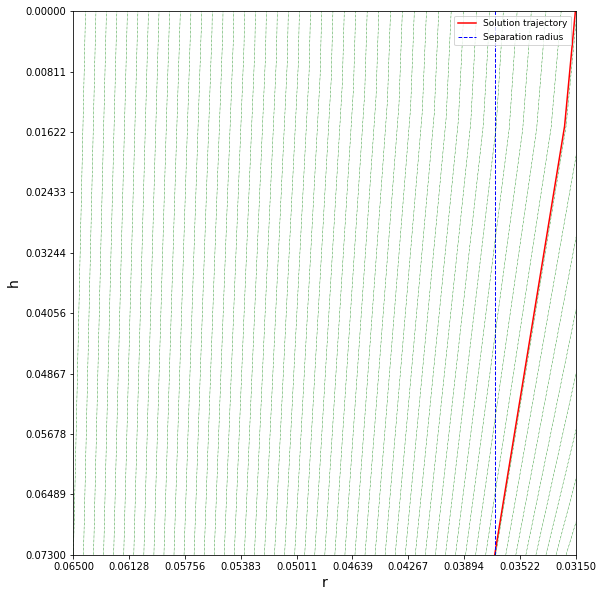

In [16]:
plt.figure(figsize=(9,10))

# print(slo_list_to_plot[sol_list.index(i)].y[0])
# print(slo_list_to_plot[sol_list.index(i)].t)
plt.plot(slo_list_to_plot[sol_list.index(i)].y[0], slo_list_to_plot[sol_list.index(i)].t, 'r', lw=1.5)
plt.plot([r[sol_list.index(i)], r[sol_list.index(i)]], [h_p, 0], 'b--', lw=1)

for sol in slo_list_to_plot[::20]:
    plt.plot(sol.y[0], sol.t, 'g-.', lw=0.4)

    
plt.legend(['Solution trajectory', 'Separation radius'], fontsize=9)

# plt.plot(sol1.t, sol1.y[0])
# plt.plot(sol1.t, sol1.y[1])
plt.xlabel('r', fontsize=14)
plt.ylabel('h', fontsize=14)

plt.ylim([h_p, 0])
plt.xlim([r_c, r_p])

plt.xticks(np.linspace(r_c, r_p, num=10, endpoint=True))
plt.yticks(np.linspace(h_p, 0, num=10, endpoint=True))

plt.show()

# Natural sep factor

In [17]:
E = (r_c**2 - (r[sol_list.index(i)])**2)/(r_c**2 - r_p**2)

print(E)

0.8857694718270319


In [18]:
# si : 0.8857694718270319
# field 1 : 0.9894548996189497
# field 2 : 0.6081482946586392